In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = [32, 16]
sns.set(rc={'figure.figsize':(15, 10)})

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('Kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

In [5]:
data[target].value_counts()

0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**

4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC.

5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

### Анализ данных и подготовка фичей

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

Пропущенные значения есть только в целевом признаке.  
Вероятно, данные сэмплы нам никак не помогут при обучении. Их можно отбросить.

In [7]:
data = data[~data['shot_made_flag'].isna()]

In [8]:
data.action_type.value_counts()

Jump Shot                          15836
Layup Shot                          2154
Driving Layup Shot                  1628
Turnaround Jump Shot                 891
Fadeaway Jump Shot                   872
Running Jump Shot                    779
Pullup Jump shot                     402
Turnaround Fadeaway shot             366
Slam Dunk Shot                       334
Reverse Layup Shot                   333
Jump Bank Shot                       289
Driving Dunk Shot                    257
Dunk Shot                            217
Tip Shot                             151
Step Back Jump shot                  106
Alley Oop Dunk Shot                   95
Floating Jump shot                    93
Driving Reverse Layup Shot            83
Hook Shot                             73
Driving Finger Roll Shot              68
Alley Oop Layup shot                  67
Reverse Dunk Shot                     61
Driving Finger Roll Layup Shot        59
Turnaround Bank shot                  58
Running Layup Sh

In [9]:
data.combined_shot_type.value_counts()

Jump Shot    19710
Layup         4532
Dunk          1056
Tip Shot       152
Hook Shot      127
Bank Shot      120
Name: combined_shot_type, dtype: int64

In [10]:
data.season.value_counts()

2005-06    1924
2002-03    1852
2008-09    1851
2007-08    1819
2009-10    1772
2001-02    1708
2006-07    1579
2000-01    1575
2010-11    1521
2011-12    1416
2003-04    1371
2012-13    1328
1999-00    1312
2004-05    1127
2015-16     932
1997-98     810
1998-99     765
2014-15     593
1996-97     383
2013-14      59
Name: season, dtype: int64

In [11]:
data.shot_type.value_counts()

2PT Field Goal    20285
3PT Field Goal     5412
Name: shot_type, dtype: int64

In [12]:
data.shot_zone_area.value_counts()

Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64

In [13]:
data.shot_zone_basic.value_counts()

Mid-Range                10532
Restricted Area           5932
Above the Break 3         4720
In The Paint (Non-RA)     3880
Right Corner 3             333
Left Corner 3              240
Backcourt                   60
Name: shot_zone_basic, dtype: int64

In [14]:
data.shot_zone_range.value_counts()

Less Than 8 ft.    7857
16-24 ft.          6907
8-16 ft.           5580
24+ ft.            5281
Back Court Shot      72
Name: shot_zone_range, dtype: int64

In [15]:
data.team_name.value_counts()

Los Angeles Lakers    25697
Name: team_name, dtype: int64

In [16]:
data.game_date.value_counts()

2016-04-13    43
2007-03-30    41
2006-01-22    39
2002-11-07    39
2008-01-14    37
              ..
1996-12-10     1
1996-11-19     1
1997-03-20     1
1997-05-06     1
1996-11-05     1
Name: game_date, Length: 1558, dtype: int64

In [17]:
data.matchup.value_counts()

LAL @ SAS      853
LAL vs. SAS    765
LAL @ PHX      751
LAL @ SAC      751
LAL vs. HOU    722
              ... 
LAL @ PHO       29
LAL vs. NOP     21
LAL vs. SAN     20
LAL @ UTH       15
LAL vs. BKN     13
Name: matchup, Length: 74, dtype: int64

In [18]:
data.opponent.value_counts()

SAS    1638
PHX    1535
HOU    1399
SAC    1397
DEN    1352
POR    1292
UTA    1238
MIN    1219
GSW    1143
LAC    1074
DAL    1033
MEM     871
BOS     783
SEA     694
IND     626
ORL     604
PHI     603
DET     587
NYK     566
OKC     561
TOR     556
MIA     517
CHI     516
CLE     514
MIL     507
WAS     501
CHA     500
NOH     475
ATL     438
NJN     422
NOP     287
VAN     204
BKN      45
Name: opponent, dtype: int64

In [19]:
data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


Обратим внимание, что признаки team_id и team_name имеют только одно значение. Их можно отбросить. 

In [20]:
data = data.drop(['team_id', 'team_name'], axis=1)

<AxesSubplot:>

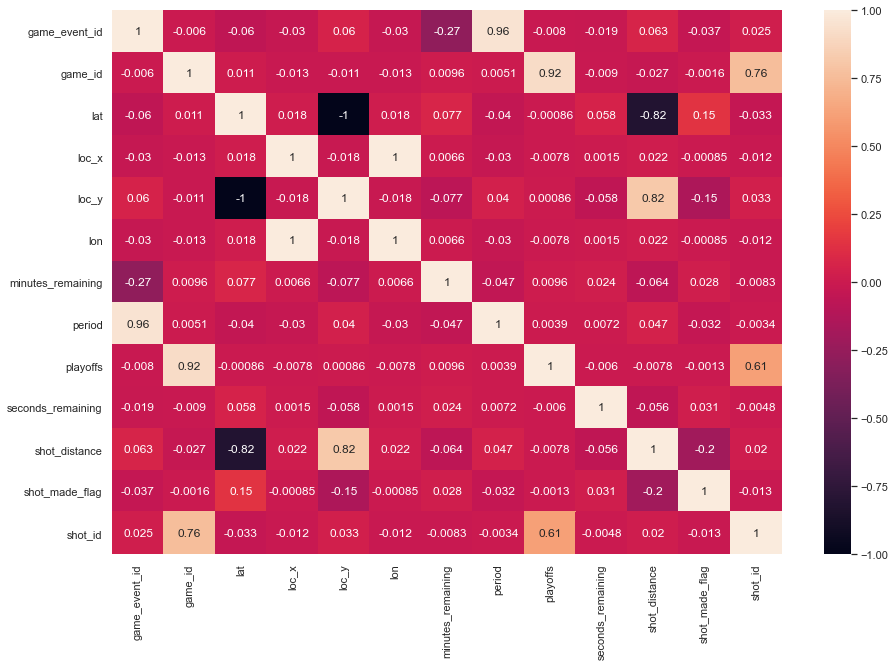

In [21]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)

Видим абсолютную корреляцию между признаками loc_x и lon, а также абсолютную отрицательную корреляцию между признаками loc_y и lat.  
Также видим крайне сильные корреляции между признаками

- game_event_id и period
- game_id и playoffs
- game_id и shot_id
- shot_distance и lat
- shot_distance и loc_y

Отбросим часть данных признаков в связи с их неифнормативностью.

In [22]:
data = data.drop(['lat', 'lon', 'game_event_id', 'game_id', 'shot_distance'], axis=1)

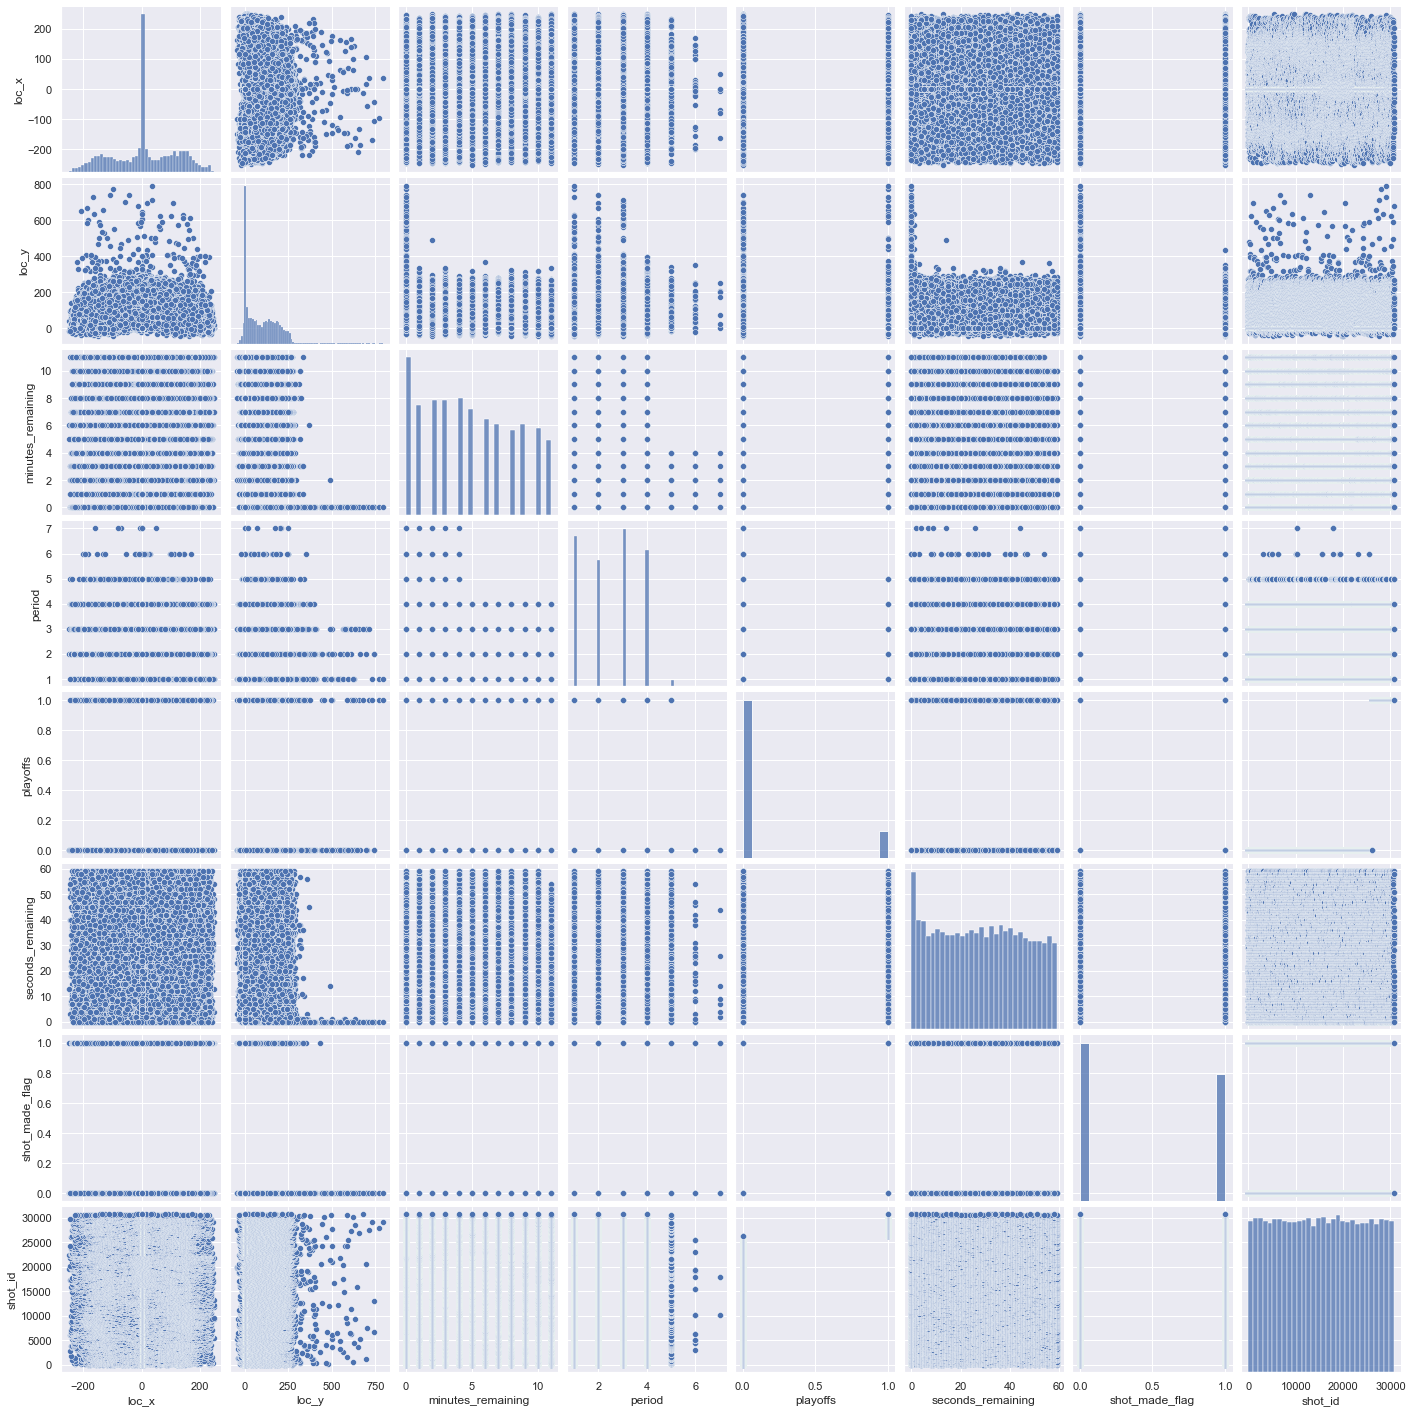

In [23]:
sns.pairplot(data)

Явные выбросы в данных отсутствуют

Разложим категориальные признаки

In [24]:
data = pd.get_dummies(data)
data.head()

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_made_flag,shot_id,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,-157,0,10,1,0,22,0.0,2,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-101,135,7,1,0,45,1.0,3,0,0,...,0,0,1,0,0,0,0,0,0,0
3,138,175,6,1,0,52,0.0,4,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,6,2,0,19,1.0,5,0,0,...,0,0,1,0,0,0,0,0,0,0
5,-145,-11,9,3,0,32,0.0,6,0,0,...,0,0,1,0,0,0,0,0,0,0


### Обучение моделей

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import  Lasso
from sklearn.linear_model import  Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [86]:
X = data.drop([target], axis = 1)
y = data[target]

In [87]:
Std = StandardScaler()
X_std = Std.fit_transform(X)

In [28]:
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state = 1)

In [65]:
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
roc_auc_score(y_test, lr.predict(X_test_std))

0.6315890131977291

In [60]:
coef = pd.DataFrame((lr.coef_.tolist()[0]), columns=['coef_lr'])
coef['coef_lr'] = abs(coef['coef_lr'])

Номера признаков, имеющие наибольший вес.  
Значения взяты по модулю, так как в контексте важности признаков важны сами величины, а не их знак.

In [44]:
list(np.linspace(0,9,10))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

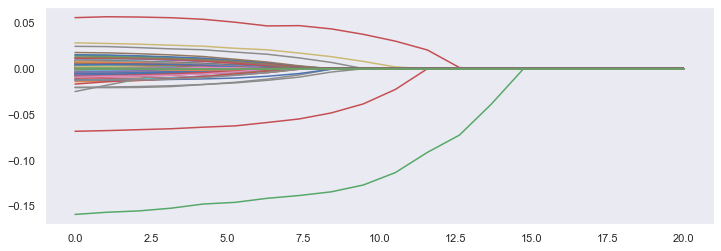

In [46]:
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,0,20))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_train_std, y_train)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

plt.figure(figsize=[12,4])
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i))  
#plt.legend(names)      
plt.grid() 

Легенду выводить не имеет смысла, ибо слишком много признаков.

Единственный вывод, который можно сделать из данного построения: среди нескольких сотен прихнаков существует 4-10 наиболее важных.

In [52]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_std, y_train)
roc_auc_score(y_test, lasso.predict(X_test_std))

0.690447401761654

In [68]:
coef['coef_las'] = list(lasso.coef_)
coef['coef_las'] = abs(coef['coef_las'])

Здесь результат совсем плохой.

Либо я что-то делаю не так, либо сама модель не предназначена для прогнозирования на столь большом количестве признаков

In [34]:
ridge = Ridge()
ridge.fit(X_train_std, y_train)
roc_auc_score(y_test, ridge.predict(X_test_std))

0.6682784496880745

На таком количестве признаков лучший результат показывает Lasso-регрессор.

In [69]:
coef['coef_ridge'] = list(ridge.coef_)
coef['coef_ridge'] = abs(coef['coef_ridge'])

In [75]:
coef.sort_values('coef_las', ascending=False).head(10)

,coef_lr,coef_ridge,coef_las
32,0.420478,0.082608,0.140080
33,0.253904,0.048622,0.057230
63,0.329461,0.038989,0.047122
18,0.217361,0.048491,0.019598
47,0.264480,0.054019,0.014521
67,0.040422,0.007119,0.011437
87,0.074258,0.009587,0.009841
90,0.158854,0.009398,0.007245
35,0.194921,0.039584,0.005993
30,0.160649,0.033632,0.005152


Отсортируем значения коээфициентов по регресии Лассо, как наилучшей из рассмотренных моделей.

Модели во многом схоже определили наиболее важные признаки. В значениях индекса датафрейма представлены их порядковые номера.

### PCA

In [123]:
from sklearn.decomposition import PCA

pca = PCA(n_components = int(X_std.shape[1]**0.5))
X_std_PCA_reduced = pca.fit_transform(X_std)

Урежем количество признаков до корня из изначального количества.

In [124]:
X_train_std_PCA_reduced, X_test_std_PCA_reduced, y_train, y_test = train_test_split(X_std_PCA_reduced, y, test_size=0.3, random_state = 1)

In [125]:
lr = LogisticRegression()
lr.fit(X_train_std_PCA_reduced, y_train)
roc_auc_score(y_test, lr.predict(X_test_std_PCA_reduced))

0.5884218490299815

In [126]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_std_PCA_reduced, y_train)
roc_auc_score(y_test, lasso.predict(X_test_std_PCA_reduced))

0.6270341199503007

In [127]:
ridge = Ridge()
ridge.fit(X_train_std_PCA_reduced, y_train)
roc_auc_score(y_test, ridge.predict(X_test_std_PCA_reduced))

0.622859214441083

Качество всех трех моделей несколько уменьшилось.